In [ ]:
import pandas as pd
import networkx as nx
try:
    data = pd.read_csv('/content/amazon_reviews.csv' , nrows=50)
except pd.errors.ParserError:
    data = pd.read_csv('/content/amazon_reviews.csv', error_bad_lines=False)

print(data.columns)


Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote'],
      dtype='object')


Text Preocessing for the description

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def text_preprocessing(text):
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

columns_to_process = ['description', 'summary', 'reviewText']
for column in columns_to_process:
    data[column + '_processed'] = data[column].apply(lambda x: text_preprocessing(x) if pd.notnull(x) else '')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


converting categorical data into numerical data



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['verified', 'brand', 'category', 'itemName', 'userName']

# Initialize LabelEncoders for each column
label_encoders = {}

for col in columns_to_encode:
    if col == 'itemName':
        # If the column is 'itemName', encode and drop duplicates
        label_encoder = LabelEncoder()
        data[col + '_encoded'] = label_encoder.fit_transform(data[col])
        data = data.drop_duplicates(subset=[col + '_encoded'])
    else:
        # For other columns, just encode
        label_encoder = LabelEncoder()
        data[col + '_encoded'] = label_encoder.fit_transform(data[col])

    # Save the label encoder for potential future use (e.g., inverse_transform)
    label_encoders[col] = label_encoder

<ipython-input-28-38d8dd2d9566>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_encoded'] = label_encoder.fit_transform(data[col])


In [ ]:
from tabulate import tabulate

print("Columns of the dataset:")
print(tabulate([data.columns], headers='keys', tablefmt='pretty'))

print("\nTop 5 Values Before:")
top_5_values_before = data[['userName','verified', 'brand', 'category', 'itemName']].head(5)
print(tabulate(top_5_values_before, headers='keys', tablefmt='pretty'))

print("\nTop 5 Encoded Values:")
top_5_values = data[['userName_encoded','verified_encoded', 'brand_encoded', 'category_encoded', 'itemName_encoded']].head(5)
print(tabulate(top_5_values, headers='keys', tablefmt='pretty'))

Columns of the dataset:
+----------+----------+----------+-------------+-------+-------+---------+----------+-------+--------+------------+---------+------------+------+------------------+---------------+------------------+------------------+------------------+
|    0     |    1     |    2     |      3      |   4   |   5   |    6    |    7     |   8   |   9    |     10     |   11    |     12     |  13  |        14        |      15       |        16        |        17        |        18        |
+----------+----------+----------+-------------+-------+-------+---------+----------+-------+--------+------------+---------+------------+------+------------------+---------------+------------------+------------------+------------------+
| userName | verified | itemName | description | image | brand | feature | category | price | rating | reviewTime | summary | reviewText | vote | verified_encoded | brand_encoded | category_encoded | itemName_encoded | userName_encoded |
+----------+----------+-

label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['brand_encoded'] = label_encoder.fit_transform(data['brand'].astype(str))


*data* scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data['price'] = pd.to_numeric(data['price'].replace({'\$': '', ',': '', '^[^\d\.]': '0'}, regex=True), errors='coerce').fillna(0)

scaler = MinMaxScaler()
data['price_scaled'] = scaler.fit_transform(data[['price']])


Graph creation

In [ ]:
data['price_scaled'] = data['price_scaled'].replace('[\$,]', '', regex=True).astype(float)

price_ranges = data.groupby('category')['price_scaled'].agg(['min', 'max'])

print(price_ranges)

                             min       max
category                                  
Arts_Crafts_and_Sewing       0.0  0.249002
Cell_Phones_and_Accessories  0.0  0.599956
Grocery_and_Gourmet_Food     0.0  0.098991
Industrial_and_Scientific    0.0  0.425004
Luxury_Beauty                0.0  0.429004
Musical_Instruments          0.0  0.139991
Office_Products              0.0  0.449104
Patio_Lawn_and_Garden        0.0  0.657067
Pet_Supplies                 0.0  1.000000
Prime_Pantry                 0.0  0.039990
Software                     0.0  0.099951
Video_Games                  0.0  0.164912


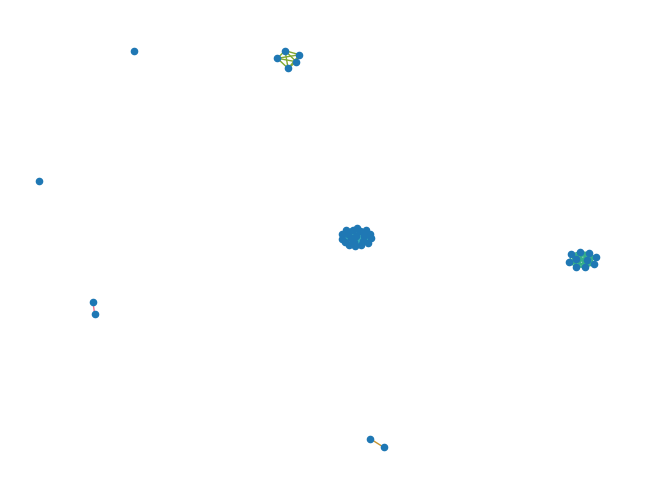

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
G = nx.Graph()

# Group items by category
category_dict = data.groupby('category_encoded')['itemName'].apply(list).to_dict()

# Generate a color palette for each category
num_categories = len(category_dict)
category_colors = sns.color_palette("husl", num_categories)

# Assign colors to categories using unique category identifiers
category_mapping = {category: f"Category_{i}" for i, category in enumerate(category_dict.keys())}
category_color_mapping = {category_mapping[category]: color for category, color in zip(category_dict.keys(), category_colors)}

# Add nodes and edges to the graph
for items in category_dict.values():
    G.add_nodes_from(items)

for category, items in category_dict.items():
    category_color = category_color_mapping[category_mapping[category]]
    for i, item1 in enumerate(items):
        for item2 in items[i + 1:]:
            G.add_edge(item1, item2, category_color=category_color)

# Draw the graph with category-specific colors
pos = nx.spring_layout(G)
edge_colors = [G[u][v]['category_color'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=20, font_size=8, edge_color=edge_colors)
plt.show()


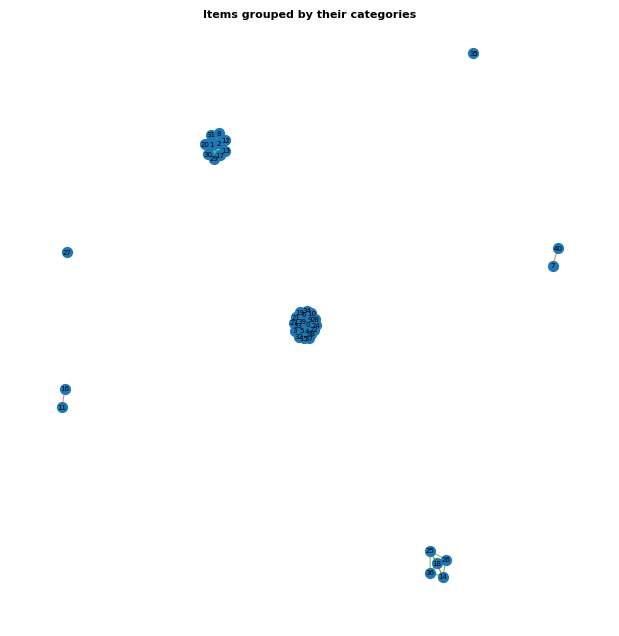

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
G = nx.Graph()

# Group items by category
category_dict = data.groupby('category')['itemName_encoded'].apply(list).to_dict()

# Add nodes for each item
for items in category_dict.values():
    G.add_nodes_from(items)

# Add edges between items in the same category
for items in category_dict.values():
    for i, item1 in enumerate(items):
        for item2 in items[i + 1:]:
            G.add_edge(item1, item2)

# shortened_labels = {node: node[0] for node in G.nodes}
# print(shortened_labels)
# Draw the graph
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
nx.draw(G, with_labels=True, font_weight='light', node_size=50, font_size=5, edge_color=edge_colors, width=0.7)
plt.title("Items grouped by their categories", fontsize=8, fontweight='bold')
plt.gca().set_frame_on(True)

plt.box(on=None)

plt.show()



In [ ]:
num_nodes = len(G.nodes)
num_edges = len(G.edges)

print("Number of nodes", num_nodes)
print("Number of edges", num_edges)

Number of nodes 157
Number of edges 155


Added edges based on the 'description_processed' column using cosine similarity as weights in the graph G.

Cosine Similarity: Measures the cosine of the angle between two non-zero vectors. It's frequently used in text analysis to determine the similarity between documents or feature.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

description_processed = data['description_processed'].apply(lambda words: ' '.join(words)).tolist()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(description_processed)

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

threshold = 0.6

num_items = len(data)
for i in range(num_items):
    for j in range(i + 1, num_items):
        if cosine_sim[i][j] > threshold:
            G.add_edge(data['itemName_encoded'].iloc[i], data['itemName_encoded'].iloc[j], weight=cosine_sim[i][j])



NameError: ignored

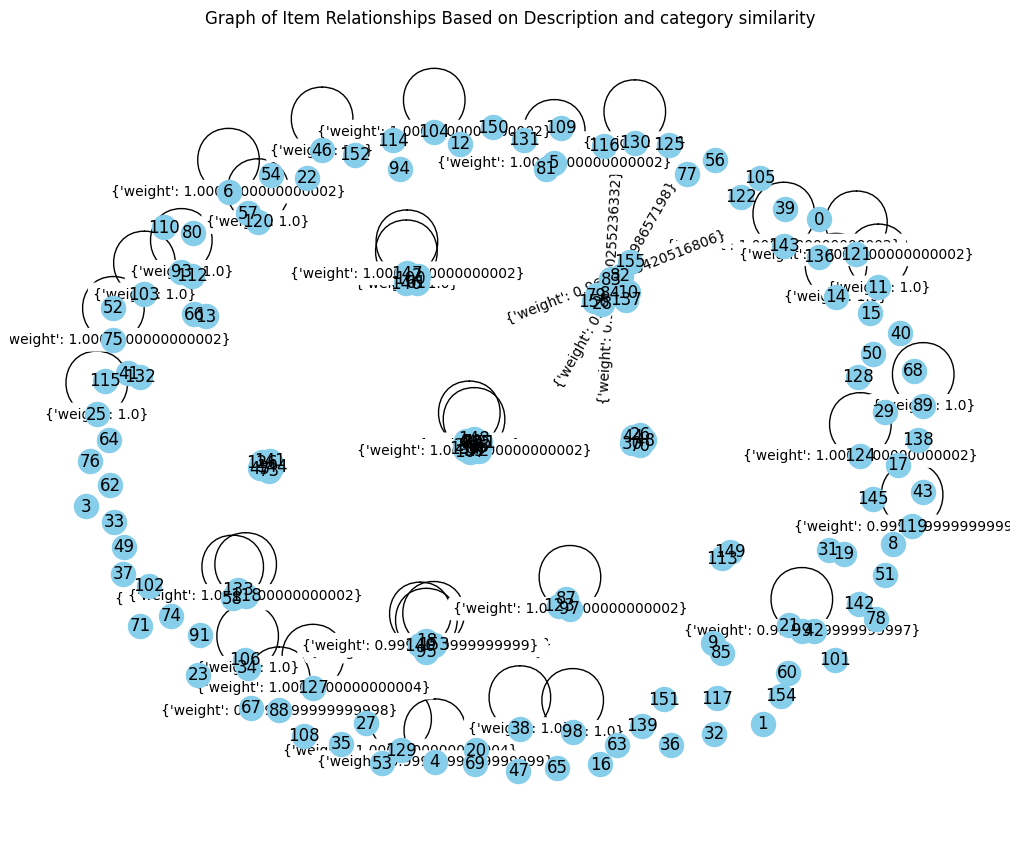

In [ ]:
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G)

nx.draw(G, pos, node_color='skyblue', with_labels=True, node_size=300)
nx.draw_networkx_edge_labels(G, pos)

# Display the graph
plt.title("Graph of Item Relationships Based on Description and category similarity")
plt.axis('off')
plt.show()

In [ ]:
num_nodes = len(G.nodes)
num_edges = len(G.edges)

print("Number of nodes", num_nodes)
print("Number of edges", num_edges)

Number of nodes 157
Number of edges 193


In [ ]:
max_degree = max(dict(G.degree()).values())

min_degree = min(dict(G.degree()).values())

average_degree = sum(dict(G.degree()).values()) / len(G)

largest_connected_component = max(nx.connected_components(G), key=len)
size_of_largest_connected_component = len(largest_connected_component)

num_connected_components = nx.number_connected_components(G)

assortativity = nx.degree_assortativity_coefficient(G)

average_clustering_coefficient = nx.average_clustering(G)

print("Max Degree:", max_degree)
print("Min Degree:", min_degree)
print("Average Degree:", average_degree)
print("Size of Largest Connected Component:", size_of_largest_connected_component)
print("Number of Connected Components:", num_connected_components)
print("Assortativity:", assortativity)
print("Average Clustering Coefficient:", average_clustering_coefficient)


Max Degree: 15
Min Degree: 0
Average Degree: 2.4585987261146496
Size of Largest Connected Component: 14
Number of Connected Components: 105
Assortativity: 0.9636762460438641
Average Clustering Coefficient: 0.2902638762511374


In [ ]:
print(data.shape)

(7243, 23)


Collaborative filtering with matrix factorization technique.
captures interaction of user with itemName




In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163767 sha256=b2b532b5cd4c7586396178d1a5302ed217807e29d4db68f4a377e12397438316
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Reader,Dataset
from surprise import BaselineOnly, SVD, SVDpp
import surprise

In [ ]:
import pandas as pd

# Assuming 'data' is your DataFrame
user_counts = data['userName_encoded'].value_counts()

# Find the user with the maximum count
user_to_remove = user_counts.idxmax()

# Remove the user with the maximum count from the dataset
removed_max = data[data['userName_encoded'] != user_to_remove]

# Now 'filtered_data' does not contain the user with the maximum count
print(f"Removed user with ID {user_to_remove}. New dataset shape: {removed_max.shape}")


Removed user with ID 137. New dataset shape: (1572, 23)


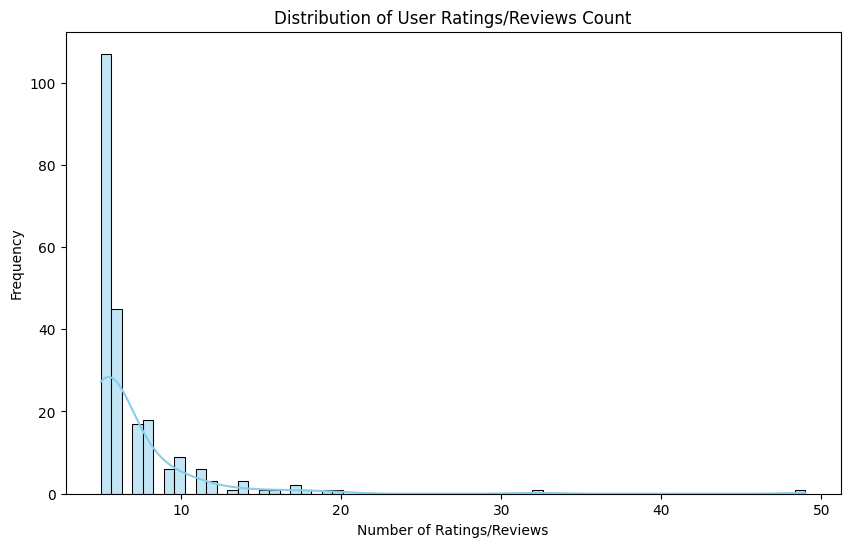

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
user_counts = removed_max['userName_encoded'].value_counts()

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(user_counts, kde=True, color='skyblue')
plt.title('Distribution of User Ratings/Reviews Count')
plt.xlabel('Number of Ratings/Reviews')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd

user_ratings_count = data['userName_encoded'].value_counts()

# Filter users with less than 2 ratings
users_with_less_than_2_ratings = user_ratings_count[user_ratings_count < 4].index
print("Number of rows before filtering:", len(data))

# Remove rows corresponding to users with less than 2 ratings
data = data[~data['userName_encoded'].isin(users_with_less_than_2_ratings)]

# Now, 'filtered_data' contains only the rows with users who have 2 or more ratings
print("Number of rows after filtering:", len(data))


Number of rows before filtering: 1928
Number of rows after filtering: 1928


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming 'filtered_data' is your DataFrame
# Assuming 'userName_encoded' is the column containing user IDs
# Assuming 'itemID_encoded' is the column containing item IDs

# Define the grouping by user
grouped_data = data.groupby('userName_encoded')

# Initialize empty DataFrames for train and test sets
train_set = pd.DataFrame()
test_set = pd.DataFrame()

# Iterate over each group (user)
for user, group in grouped_data:
    # Split each user's items into train and test sets
    user_train, user_test = train_test_split(group, test_size=0.2, random_state=42)

    # Concatenate the splits to the overall train and test sets
    train_set = pd.concat([train_set, user_train])
    test_set = pd.concat([test_set, user_test])

# Print the shapes of the resulting train and test sets
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)


Train set shape: (1476, 23)
Test set shape: (452, 23)


In [ ]:
#X_train, X_test = train_test_split(data, test_size=0.05, shuffle=False)
data[:int(len(data)*0.8)].to_csv('xtrain.csv', index=False)
data[int(len(data)*0.8):].to_csv('xtest.csv', index=False)

X_train = pd.read_csv('xtrain.csv')
X_test = pd.read_csv('xtest.csv')
print(X_train.shape)
print(X_test.shape)

(1542, 23)
(386, 23)


In [ ]:
train_ratings = X_train[['userName_encoded','itemName_encoded','rating']]
test_ratings = X_test[['userName_encoded','itemName_encoded','rating']]
print(data.columns)


Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote', 'description_processed', 'summary_processed',
       'reviewText_processed', 'verified_encoded', 'brand_encoded',
       'category_encoded', 'itemName_encoded', 'userName_encoded',
       'price_scaled'],
      dtype='object')


In [ ]:
print(set(train_ratings['userName_encoded']))
print(set(train_ratings['rating']))

{515, 3590, 2568, 2571, 1549, 1550, 3088, 531, 3091, 2070, 1046, 2072, 1048, 3097, 1564, 1054, 2080, 2593, 2082, 34, 1062, 39, 2095, 559, 1591, 2615, 2105, 570, 2047, 2108, 2109, 3646, 581, 585, 3146, 587, 2124, 2640, 2135, 3673, 1629, 2143, 607, 3169, 1634, 615, 621, 2158, 2670, 3693, 2673, 2162, 114, 2164, 1650, 3188, 1652, 118, 3701, 1154, 3204, 645, 134, 137, 138, 1676, 1166, 1679, 2706, 1171, 1684, 2195, 663, 665, 1690, 3739, 1692, 157, 156, 3236, 3237, 3754, 1707, 2734, 177, 188, 2240, 3776, 2242, 2243, 3268, 1740, 1743, 210, 2775, 729, 2778, 731, 2781, 226, 3300, 231, 1257, 2797, 2798, 2799, 2803, 1267, 2805, 757, 2294, 3321, 3833, 2813, 3839, 3328, 2304, 1285, 1288, 3340, 2833, 786, 3347, 791, 804, 2853, 2855, 1320, 1836, 819, 1331, 307, 1334, 3382, 824, 3385, 825, 1852, 1344, 3393, 1858, 836, 1349, 1863, 2894, 1871, 2896, 3411, 342, 1879, 2393, 2908, 349, 350, 3420, 862, 1890, 355, 2928, 371, 1397, 1402, 1403, 2939, 2947, 2951, 2441, 395, 1420, 3469, 2450, 1940, 1945, 926, 143

In [ ]:
import pandas as pd

user_counts = data['userName_encoded'].value_counts()
print(user_counts)
# Find the user with the maximum count
user_with_max_count = user_counts.idxmax()
max_count = user_counts.max()

print("User with the maximum count of ratings or reviews:")
print("User:", user_with_max_count)
print("Maximum Count:", max_count)


137     356
2164     49
665      32
1684     20
1707     19
       ... 
3146      5
1349      5
471       5
2980      5
1436      5
Name: userName_encoded, Length: 225, dtype: int64
User with the maximum count of ratings or reviews:
User: 137
Maximum Count: 356


In [ ]:
import pandas as pd

# Assuming your dataset is stored in a DataFrame called 'data'
# Adjust column names as needed

# Count the number of ratings per user
user_counts = data['userName'].value_counts()

# Calculate the average count of ratings
average_ratings_count = user_counts.mean()

print("Average count of ratings per user:", average_ratings_count)


Average count of ratings per user: 8.568888888888889


In [ ]:
import pandas as pd

# Assuming 'userName_encoded' is the column containing user IDs
user_id = 1684

# Assuming 'data' is your DataFrame
filtered_data = data[data['userName_encoded'] == user_id]

if not filtered_data.empty:
    # Display the user's ratings before removal
    print("User's Ratings Before Removal:")
    table = tabulate(filtered_data[['userName', 'itemName', 'category', 'rating']], headers='keys', tablefmt='pretty')
    print(table)
    print(f"Number of entries before removal: {len(filtered_data)}")


    # Choose 5 reviews to remove, for example, the first 5
    reviews_to_remove = filtered_data.head(5)

    # Remove the chosen reviews from the DataFrame
    data_temp = data.drop(reviews_to_remove.index)

    # Display the user's ratings after removal
    print("\nUser's Ratings After Removal:")
    table = tabulate(filtered_data[['userName', 'itemName', 'category', 'rating']], headers='keys', tablefmt='pretty')
    print(table)
    print(f"Number of entries after removal: {len(data_temp[data_temp['userName_encoded'] == user_id])}")
    print("\nList of Removed Items:")
    table = tabulate(reviews_to_remove[['userName', 'itemName', 'category', 'rating']], headers='keys', tablefmt='pretty')
    print(table)


else:
    print(f"No ratings found for user {user_id}")


User's Ratings Before Removal:
+------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------+--------+
|      |  userName   |                                                                                              itemName                                                                                               |          category           | rating |
+------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------+--------+
| 175  | KentuckyRob |                                         Huaxia Datacom Natural Tree Camo Defender Design Military Grade Hybrid Case For Samsung Galaxy S4 SIV I9500 - Pink            

In [ ]:
#Trainset
reader = Reader(rating_scale=(1.0,5.0))
data_df = Dataset.load_from_df(train_ratings,reader)
trainset = data_df.build_full_trainset()

#Testset
#list of list (or tuples)==> (user, id, rating)
testset = test_ratings.values


In [ ]:
import numpy as np

def get_predictions(results):
    true = np.array([i.r_ui for i in results])
    pred = np.array([i.est for i in results])
    return true,pred

def rmse(true,pred):
    return np.sqrt(np.mean((true-pred)**2))

In [ ]:
bsl_options = {
    "method": "sgd",
    "learning_rate": 0.00005,
}
algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(trainset)

Estimating biases using sgd...


In [ ]:
train_test = trainset.build_testset()
train_results = algo.test(train_test)#, verbose=True)
test_results = algo.test(testset)#, verbose=True)

In [ ]:
true,pred = get_predictions(train_results)
print('Train RMSE:', rmse(true,pred))
true,pred = get_predictions(test_results)
print('Test RMSE:', rmse(true,pred))

Train RMSE: 0.9760719599132766
Test RMSE: 0.9615610780097191


In [ ]:
svd_algo = SVD(n_factors=100, biased=True, random_state=42)
svd_algo.fit(trainset)


In [ ]:
train_test = trainset.build_testset()
train_results = svd_algo.test(train_test)#, verbose=True)
test_results = svd_algo.test(testset)#, verbose=Tru

In [ ]:
true,pred = get_predictions(train_results)
print('Train RMSE:', rmse(true,pred))
true,pred = get_predictions(test_results)
print('Test RMSE:', rmse(true,pred))

Train RMSE: 0.622830255079114
Test RMSE: 0.9537920095172925


In [ ]:
svdpp_algo = SVDpp(random_state=24)
svdpp_algo.fit(trainset)
surprise.dump.dump('svdpp_algo.pkl',algo=svdpp_algo)
print('Done Dumping...!')
svdpp_algo = surprise.dump.load('svdpp_algo.pkl')[1]

Done Dumping...!


In [ ]:
train_test = trainset.build_testset()
train_results = svdpp_algo.test(train_test)#, verbose=True)
test_results = svdpp_algo.test(testset)#, verbose=True)

In [ ]:
true,pred = get_predictions(train_results)
print('Train RMSE:', rmse(true,pred))
true,pred = get_predictions(test_results)
print('Test RMSE:', rmse(true,pred))

Train RMSE: 0.5795010046998782
Test RMSE: 0.9523185876206803


In [ ]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model', 'Train RMSE', 'Test RMSE']
x.add_row(['BaselineOnly', str(np.round(0.976071959913276, 4)), str(np.round(0.9615610780097191, 4))])
x.add_row(['SVD', str(np.round(0.622830255079114, 4)), str(np.round(0.9537920095172925, 4))])
x.add_row(['SVD++', str(np.round(0.5795010046998782, 4)), str(np.round(0.9523185876206803, 4))])
print(x)

+--------------+------------+-----------+
|    Model     | Train RMSE | Test RMSE |
+--------------+------------+-----------+
| BaselineOnly |   0.9761   |   0.9616  |
|     SVD      |   0.6228   |   0.9538  |
|    SVD++     |   0.5795   |   0.9523  |
+--------------+------------+-----------+


In [ ]:
def recommend_10(user_id, svd_algo):
    item_bought = set(train_ratings[train_ratings.userName_encoded==user_id].itemName_encoded.values)
    filtered_data1 = data[data['userName_encoded'] == user_id]
    if not filtered_data1.empty:
      display_data = filtered_data1[['userName', 'itemName', 'category']]

      # Convert the DataFrame to a table format
      table = tabulate(display_data, headers='keys', tablefmt='pretty', showindex=False)

      # Print the table
      print(table)
    else:
      print("No data found for userName_encoded =", user_id)
    if len(item_bought)==0:
        return 'User new to the platform'

    item_unbought = set(data.itemName_encoded) - item_bought

    results = []
    for mid in item_unbought:
        results.append(svd_algo.predict(user_id, mid))

    df =  pd.DataFrame([(i.iid,i.est) for i in results], columns=['itemName_encoded', 'rating']).sort_values('rating', ascending=False)
    top10_ids = df.itemName_encoded[:10]
    print(len(top10_ids))
    return data[data.itemName_encoded.isin(top10_ids)][['itemName', 'category', 'rating']]#, top10_ids

In [ ]:
recommend_10(2164, svdpp_algo)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------+
| userName |                                                                                             itemName                                                                                             |          category           |
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------+
|   Mike   |         iCarez [Anti Glare] Screen Protector for Samsung Galaxy S7 (Case Friendly) [Unique Hinge Install Method with Kits ] 3-Pack with Lifetime Replacement Warranty - Retail Packaging         | Cell_Phones_and_Accessories |
|   Mike   |                                    

,itemName,category,rating
155,Seachem Flourish 500ml,Pet_Supplies,5.0
303,Discontinued By Manufacturer: Solid Gold SeaMe...,Pet_Supplies,5.0
1171,Classic Accessories 55-648-051501-00 Veranda P...,Patio_Lawn_and_Garden,5.0
2056,The Sims 3: Pets Expansion Pack,Video_Games,5.0
2503,Pet Dog Cat Puppy Kitten Soft Blanket Doggy Wa...,Pet_Supplies,4.0
2800,TurboTax Deluxe Federal + State 2007 [OLD VERS...,Software,5.0
3483,"Apoxie Sculpt 1/4 lb. White, 2 part modeling c...",Arts_Crafts_and_Sewing,5.0
3949,"MarineLand Emperor Filter Systems, 400B",Pet_Supplies,5.0
5205,DYMO Standard D1 45015 Labeling Tape (Red Prin...,Office_Products,5.0
6131,Dr. Harvey'S Incredible Blend Natural Food For...,Pet_Supplies,5.0


In [ ]:
def user_products(user):
  import pandas as pd

  user_id = user

  # Assuming 'data' is your DataFrame
  filtered_data = data[data['userName_encoded'] == user_id]
  category_counts = filtered_data['category'].value_counts()

  return category_counts

user_products(2164)

Pet_Supplies                   24
Patio_Lawn_and_Garden           6
Video_Games                     5
Cell_Phones_and_Accessories     4
Grocery_and_Gourmet_Food        4
Office_Products                 3
Industrial_and_Scientific       2
Musical_Instruments             1
Name: category, dtype: int64